# Changing the spectra per epoch

In [37]:
import os
import numpy as np
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import os
from concurrent.futures import ThreadPoolExecutor
import time
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from tensorflow.keras.callbacks import EarlyStopping




In [9]:

def generate_file_list(limit_per_dir = 10000):
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(os.getcwd(), dir_name)
        dir_files = []

        # Collect all files in the directory
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                dir_files.append(file_path)
        
        # Randomly select files up to the limit
        if len(dir_files) > limit_per_dir:
            selected_files = random.sample(dir_files, limit_per_dir)
        else:
            selected_files = dir_files
        
        # Append selected files and their labels
        file_list.extend(selected_files)
        labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels



def load_spectra(file_list, known_rows=None):
    spectra_data = []
    if known_rows is None:
        known_rows = np.inf
        for file_path in tqdm(file_list, desc="Finding min rows", unit="file"):
            try:
                with fits.open(file_path) as hdul:
                    spectra = hdul[0].data[0]
                    known_rows = min(known_rows, len(spectra))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    print(f"\nLoading spectra (truncated to {known_rows} rows)...")
    for file_path in tqdm(file_list, desc="Loading spectra", unit="file"):
        try:
            with fits.open(file_path) as hdul:
                spectra = hdul[0].data[0][:known_rows]
                normalized_spectra = normalize_spectra(spectra)
                spectra_data.append(normalized_spectra)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    spectra_data = np.array(spectra_data)
    return spectra_data

def create_dataset(file_list, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_parse(file_path, label):
        spectra = tf.py_function(load_spectra, [file_path], tf.float32)
        return spectra, label

    dataset = dataset.map(load_and_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(file_list)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset
def split_dataset(file_list, labels, val_split=0.2):
    total_size = len(file_list)
    val_size = int(val_split * total_size)
    
    indices = np.random.permutation(total_size)
    train_indices, val_indices = indices[val_size:], indices[:val_size]
    
    train_files = [file_list[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    val_files = [file_list[i] for i in val_indices]
    val_labels = [labels[i] for i in val_indices]
    
    return train_files, train_labels, val_files, val_labels

def normalize_spectra(spectra):
    """Normalize spectra by dividing by the mean and applying the natural logarithm."""
    mean_value = np.mean(spectra)
    std_value = np.std(spectra)
    min_value = np.min(spectra)
    if std_value == 0:
        print("Warning: Standard deviation is zero, cannot normalize spectra.")
        return spectra  # Avoid division by zero
    normalized_spectra = ((spectra - min_value  + 0.01) / (mean_value - min_value + 0.01)) - 1 # min_value is added to avoid negative values
    return normalized_spectra

def load_single_spectrum(file_path, target_length=len_):
    """Load and normalize a single spectrum from a FITS file, truncating or padding to target_length."""
    try:
        with fits.open(file_path) as hdul:
            spectra = hdul[0].data[0]
            spectra = normalize_spectra(spectra)
            
            # Truncate or pad spectra to ensure uniform length
            if len(spectra) > target_length:
                spectra = spectra[:target_length]  # Truncate
            else:
                spectra = np.pad(spectra, (0, max(0, target_length - len(spectra))), mode='constant')  # Pad with zeros
            
            return spectra
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if there's an error

def load_all_spectra_parallel(file_list, target_length=3748, max_workers_=512):
    """Load and normalize spectra in parallel using ThreadPoolExecutor."""
    spectra_data = []
    
    with ThreadPoolExecutor(max_workers=max_workers_) as executor:
        # Use ThreadPoolExecutor to parallelize the loading of FITS files
        results = list(tqdm(executor.map(lambda f: load_single_spectrum(f, target_length), file_list), 
                            total=len(file_list), desc="Loading spectra"))

    # Filter out None results (in case any files failed to load)
    spectra_data = [spectrum for spectrum in results if spectrum is not None]

    return np.array(spectra_data)

## Convnet function

In [4]:
def create_convnet(input_shape, num_classes, 
                   num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                   kernel_size=(9,),
                   dense_units=128, 
                   dropout_rate=0.5,
                   padding='same'):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape, padding=padding))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Additional convolutional layers
    for filters in num_filters[1:]:
        model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                         activation='relu', padding=padding))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Flatten the output and add dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=dense_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.AdamW(learning_rate=1e-4)

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [7]:
len_ = 3748
file_list, labels = generate_file_list(limit_per_dir=1)

# Now use these datasets to train the model
convnet_model = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)))

convnet_model.summary()

Gathering FITS files...
Total spectra files collected: 4


/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 3738, 128)      │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1869, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1869, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 934, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 934, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 467, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 467, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 233, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 233, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 116, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 116, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 58, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 58, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 29, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,264,388 (4.82 MB)

 Trainable params: 1,264,388 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Create TensorFlow datasets using the loaded data
def create_tf_dataset(spectra_data, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((spectra_data, labels))
    dataset = dataset.shuffle(buffer_size=len(spectra_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [34]:
def removenan(train_spectra, train_labels, val_spectra, val_labels): 
   # Convert lists to NumPy arrays (remove first 10 spectra to avoid excess NaN values)
    train_spectraa = np.array(train_spectra[10:, :])
    train_labelsa = np.array(train_labels[10:])

    val_spectraa = np.array(val_spectra[10:, :])
    val_labelsa = np.array(val_labels[10:])

    # Remove nan values from the spectra
    mask_train = ~np.isnan(train_spectraa).any(axis=1)
    train_spectranan = train_spectraa[mask_train]
    train_labelsnan = train_labelsa[mask_train]

    mask_val = ~np.isnan(val_spectraa).any(axis=1)
    val_spectranan = val_spectraa[mask_val]
    val_labelsnan = val_labelsa[mask_val]

    del val_spectraa, val_labelsa, mask_val, train_spectraa, train_labelsa, mask_train
    gc.collect()

    # Create TensorFlow datasets
    train_dataset = create_tf_dataset(train_spectranan, train_labelsnan)
    val_dataset = create_tf_dataset(val_spectranan, val_labelsnan)

    del train_spectranan, train_labelsnan
    gc.collect()
    return train_dataset, val_dataset

In [35]:
def generate_random_dataset(lim_per_label = 2000):
    # Example usage:
    file_list, labels = generate_file_list(limit_per_dir=lim_per_label)
    # Convert labels to numpy array
    labels = np.array(labels)
    # Continue with creating train/validation datasets
    train_files, train_labels, val_files, val_labels = split_dataset(file_list, labels)
    # Load training and validation spectra in parallel
    train_spectra = load_all_spectra_parallel(train_files, target_length=len_)
    val_spectra = load_all_spectra_parallel(val_files, target_length=len_)
    # Create TensorFlow datasets
    train_dataset, val_dataset = removenan(train_spectra, train_labels, val_spectra, val_labels)
    return train_dataset, val_dataset


In [36]:
train_dataset, val_dataset = generate_random_dataset(lim_per_label = 2000)

Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 558.30it/s]


In [38]:
# Function to train the model with the training and validation datasets
def train_convnet(model, lim_per_label = 2000, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    train_dataset, val_dataset = generate_random_dataset(lim_per_label = lim_per_label)
    # Fit the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history

In [39]:
def train_convnet_many_times(model, epochs_per_run=1, batch_size=32, num_runs=10):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, epochs=epochs_per_run , batch_size=batch_size)
        histories.append(history)
    return histories

## Training it

In [47]:
histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=32, num_runs=25)

Training run 1/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 572.96it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7196 - loss: 0.6073 - val_accuracy: 0.7704 - val_loss: 0.5182
Training run 2/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 577.24it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7395 - loss: 0.5863 - val_accuracy: 0.7755 - val_loss: 0.5126
Training run 3/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 565.75it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7426 - loss: 0.5584 - val_accuracy: 0.7465 - val_loss: 0.5090
Training run 4/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 580.87it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7658 - loss: 0.5298 - val_accuracy: 0.7434 - val_loss: 0.5373
Training run 5/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 584.60it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7598 - loss: 0.5340 - val_accuracy: 0.7748 - val_loss: 0.4909
Training run 6/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 589.42it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7576 - loss: 0.5091 - val_accuracy: 0.7711 - val_loss: 0.4825
Training run 7/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 681.35it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7643 - loss: 0.5043 - val_accuracy: 0.7610 - val_loss: 0.4927
Training run 8/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 594.98it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7555 - loss: 0.5063 - val_accuracy: 0.7698 - val_loss: 0.4793
Training run 9/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 583.68it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7553 - loss: 0.5674 - val_accuracy: 0.7692 - val_loss: 0.4894
Training run 10/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 606.86it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7539 - loss: 0.5152 - val_accuracy: 0.7698 - val_loss: 0.4810
Training run 11/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 661.32it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7660 - loss: 0.4943 - val_accuracy: 0.7742 - val_loss: 0.4499
Training run 12/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 603.32it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7702 - loss: 0.4806 - val_accuracy: 0.7811 - val_loss: 0.4536
Training run 13/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 683.41it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7756 - loss: 0.4819 - val_accuracy: 0.7836 - val_loss: 0.4585
Training run 14/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 595.52it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7778 - loss: 0.4562 - val_accuracy: 0.7843 - val_loss: 0.4505
Training run 15/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 603.13it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7895 - loss: 0.4629 - val_accuracy: 0.7893 - val_loss: 0.4446
Training run 16/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 583.86it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7920 - loss: 0.4422 - val_accuracy: 0.7987 - val_loss: 0.4385
Training run 17/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 669.65it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7841 - loss: 0.4678 - val_accuracy: 0.8119 - val_loss: 0.4324
Training run 18/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 592.46it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7798 - loss: 0.4446 - val_accuracy: 0.7704 - val_loss: 0.4469
Training run 19/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 563.01it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7899 - loss: 0.4358 - val_accuracy: 0.7899 - val_loss: 0.4342
Training run 20/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 598.66it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7858 - loss: 0.4650 - val_accuracy: 0.7975 - val_loss: 0.4386
Training run 21/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 685.94it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7879 - loss: 0.4460 - val_accuracy: 0.8176 - val_loss: 0.4157
Training run 22/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 614.52it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7912 - loss: 0.4556 - val_accuracy: 0.8088 - val_loss: 0.4279
Training run 23/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 595.09it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7996 - loss: 0.4331 - val_accuracy: 0.8214 - val_loss: 0.3775
Training run 24/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 571.73it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8007 - loss: 0.4364 - val_accuracy: 0.8006 - val_loss: 0.4088
Training run 25/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 604.75it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7917 - loss: 0.4417 - val_accuracy: 0.7887 - val_loss: 0.4479


In [50]:
# Save the model
convnet_model.save('convnet_model_v1.keras')

In [48]:
def print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan):   
    # Make predictions on the validation/test dataset
    val_predictions = convnet_model.predict(val_spectranan)

    # Convert the predictions to class labels (assuming one-hot encoding)
    predicted_labels = np.argmax(val_predictions, axis=1)

    # Convert true labels if they are in one-hot encoded format
    true_labels = np.array(val_labelsnan)  # Assuming val_labels is already numeric


    # Generate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Optionally, print a classification report for more metrics
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'], yticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix:
[[389   4   9   0]
 [  2 318   3  76]
 [ 49   4 363   2]
 [  2 143   2 224]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       402
           1       0.68      0.80      0.73       399
           2       0.96      0.87      0.91       418
           3       0.74      0.60      0.67       371

    accuracy                           0.81      1590
   macro avg       0.82      0.81      0.81      1590
weighted avg       0.82      0.81      0.81      1590



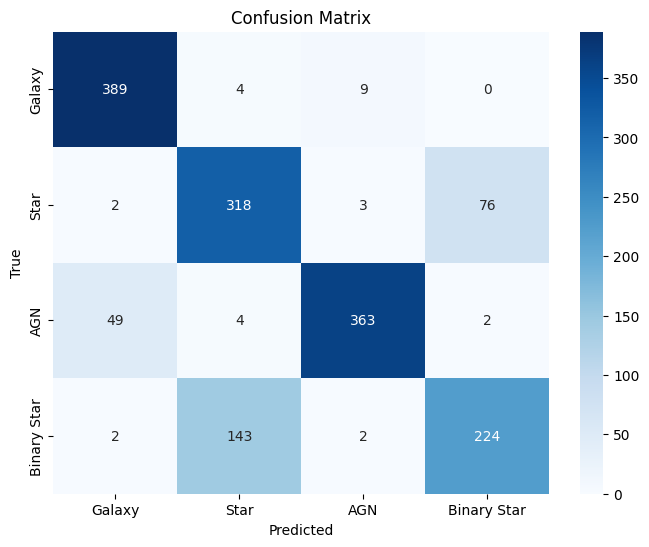

In [49]:
print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan)

# Training very deep convnet

In [51]:
filters_20=[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
model_20 = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)), num_filters=filters_20)
model_20.summary()

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 3738, 128)      │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 1869, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 1869, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 934, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 934, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 467, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 467, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 233, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 233, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 116, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 116, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 58, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 58, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 29, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 14, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 7, 128)         │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 3, 128)         │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 1, 128)         │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 0, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 0, 128)         │       147,58

 Total params: 2,806,020 (10.70 MB)

 Trainable params: 2,806,020 (10.70 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=32, num_runs=25)

Training run 1/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 660.30it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7979 - loss: 0.4470 - val_accuracy: 0.8038 - val_loss: 0.4087
Training run 2/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 658.71it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8082 - loss: 0.4176 - val_accuracy: 0.8258 - val_loss: 0.3884
Training run 3/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:03<00:00, 521.77it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8080 - loss: 0.4053 - val_accuracy: 0.7943 - val_loss: 0.4190
Training run 4/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 561.33it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8106 - loss: 0.4182 - val_accuracy: 0.8088 - val_loss: 0.4272
Training run 5/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 649.90it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8161 - loss: 0.4114 - val_accuracy: 0.8119 - val_loss: 0.3973
Training run 6/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 674.12it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7971 - loss: 0.4177 - val_accuracy: 0.8057 - val_loss: 0.4211
Training run 7/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 570.24it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8094 - loss: 0.4125 - val_accuracy: 0.8138 - val_loss: 0.4058
Training run 8/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 660.77it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8040 - loss: 0.4195 - val_accuracy: 0.8000 - val_loss: 0.3949
Training run 9/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 646.49it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8100 - loss: 0.4125 - val_accuracy: 0.8038 - val_loss: 0.4087
Training run 10/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 644.70it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8061 - loss: 0.4166 - val_accuracy: 0.8226 - val_loss: 0.3808
Training run 11/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 713.32it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8158 - loss: 0.3997 - val_accuracy: 0.8094 - val_loss: 0.3976
Training run 12/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 653.91it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8106 - loss: 0.4143 - val_accuracy: 0.8302 - val_loss: 0.3635
Training run 13/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 686.69it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8086 - loss: 0.3963 - val_accuracy: 0.8044 - val_loss: 0.4036
Training run 14/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 692.96it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8055 - loss: 0.4284 - val_accuracy: 0.8252 - val_loss: 0.3964
Training run 15/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 571.01it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8244 - loss: 0.3910 - val_accuracy: 0.8270 - val_loss: 0.3747
Training run 16/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 673.99it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8188 - loss: 0.3891 - val_accuracy: 0.8145 - val_loss: 0.3857
Training run 17/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 599.64it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8073 - loss: 0.3985 - val_accuracy: 0.8195 - val_loss: 0.3930
Training run 18/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 596.02it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8236 - loss: 0.4190 - val_accuracy: 0.8132 - val_loss: 0.3930
Training run 19/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 698.34it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8244 - loss: 0.3984 - val_accuracy: 0.8434 - val_loss: 0.3448
Training run 20/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 605.58it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8203 - loss: 0.3958 - val_accuracy: 0.8333 - val_loss: 0.3587
Training run 21/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 691.97it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8169 - loss: 0.3885 - val_accuracy: 0.8346 - val_loss: 0.3692
Training run 22/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 589.25it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8282 - loss: 0.3890 - val_accuracy: 0.8283 - val_loss: 0.3910
Training run 23/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 682.67it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8326 - loss: 0.3688 - val_accuracy: 0.8396 - val_loss: 0.3668
Training run 24/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 599.59it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8198 - loss: 0.4007 - val_accuracy: 0.8157 - val_loss: 0.3719
Training run 25/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 674.78it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8196 - loss: 0.3914 - val_accuracy: 0.8321 - val_loss: 0.3711


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Confusion Matrix:
[[400   1   1   0]
 [  1 282   1 115]
 [ 54   0 362   2]
 [  1  90   2 278]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       402
           1       0.76      0.71      0.73       399
           2       0.99      0.87      0.92       418
           3       0.70      0.75      0.73       371

    accuracy                           0.83      1590
   macro avg       0.83      0.83      0.83      1590
weighted avg       0.84      0.83      0.83      1590



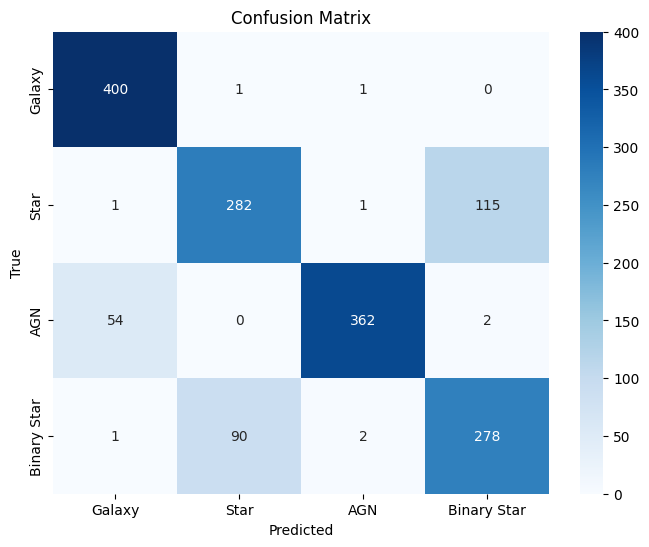

In [53]:
print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan)

# 40 layers for no sane reason

In [61]:
filters_400=[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
model_40 = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)), num_filters=filters_20, dense_units=256, dropout_rate=0.5, kernel_size=(5,))
model_40.summary()

/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_236 (Conv1D)             │ (None, 3738, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_236               │ (None, 1869, 128)      │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_237 (Conv1D)             │ (None, 1869, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_237               │ (None, 934, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_238 (Conv1D)             │ (None, 934, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_238               │ (None, 467, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_239 (Conv1D)             │ (None, 467, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_239               │ (None, 233, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_240 (Conv1D)             │ (None, 233, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_240               │ (None, 116, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_241 (Conv1D)             │ (None, 116, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_241               │ (None, 58, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_242 (Conv1D)             │ (None, 58, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_242               │ (None, 29, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_243 (Conv1D)             │ (None, 29, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_243               │ (None, 14, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_244 (Conv1D)             │ (None, 14, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_244               │ (None, 7, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_245 (Conv1D)             │ (None, 7, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_245               │ (None, 3, 128)         │             0 │
│ (MaxPooling1D)                  │                        │             

 Total params: 3,201,924 (12.21 MB)

 Trainable params: 3,201,924 (12.21 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=8, num_runs=25)

Training run 1/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 663.98it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8221 - loss: 0.3733 - val_accuracy: 0.8270 - val_loss: 0.3710
Training run 2/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 610.75it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8247 - loss: 0.3899 - val_accuracy: 0.8101 - val_loss: 0.3925
Training run 3/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 569.23it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8248 - loss: 0.3578 - val_accuracy: 0.8208 - val_loss: 0.3690
Training run 4/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 578.30it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8126 - loss: 0.3990 - val_accuracy: 0.8176 - val_loss: 0.3790
Training run 5/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 629.21it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8186 - loss: 0.3864 - val_accuracy: 0.8440 - val_loss: 0.3429
Training run 6/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 573.76it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8212 - loss: 0.3783 - val_accuracy: 0.8377 - val_loss: 0.3517
Training run 7/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 572.00it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8329 - loss: 0.3717 - val_accuracy: 0.8472 - val_loss: 0.3462
Training run 8/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 566.44it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8291 - loss: 0.3701 - val_accuracy: 0.8371 - val_loss: 0.3471
Training run 9/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 553.57it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8219 - loss: 0.3872 - val_accuracy: 0.8245 - val_loss: 0.3859
Training run 10/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 588.42it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8254 - loss: 0.3736 - val_accuracy: 0.8214 - val_loss: 0.3889
Training run 11/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 589.56it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8196 - loss: 0.3836 - val_accuracy: 0.8403 - val_loss: 0.3585
Training run 12/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 658.72it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8327 - loss: 0.3631 - val_accuracy: 0.8478 - val_loss: 0.3431
Training run 13/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 551.85it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8362 - loss: 0.3616 - val_accuracy: 0.8428 - val_loss: 0.3341
Training run 14/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 587.18it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8292 - loss: 0.3771 - val_accuracy: 0.8465 - val_loss: 0.3493
Training run 15/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 650.97it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8372 - loss: 0.3532 - val_accuracy: 0.8390 - val_loss: 0.3616
Training run 16/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 685.20it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8274 - loss: 0.3718 - val_accuracy: 0.8302 - val_loss: 0.3711
Training run 17/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 543.17it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8205 - loss: 0.3640 - val_accuracy: 0.8308 - val_loss: 0.3512
Training run 18/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 614.21it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8316 - loss: 0.3633 - val_accuracy: 0.8252 - val_loss: 0.3654
Training run 19/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 576.90it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8473 - loss: 0.3394 - val_accuracy: 0.8453 - val_loss: 0.3317
Training run 20/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 656.38it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8452 - loss: 0.3471 - val_accuracy: 0.8365 - val_loss: 0.3612
Training run 21/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 564.17it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8273 - loss: 0.3755 - val_accuracy: 0.8447 - val_loss: 0.3422
Training run 22/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 574.48it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8381 - loss: 0.3599 - val_accuracy: 0.8478 - val_loss: 0.3429
Training run 23/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 553.27it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8341 - loss: 0.3587 - val_accuracy: 0.8396 - val_loss: 0.3395
Training run 24/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 583.34it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8289 - loss: 0.3566 - val_accuracy: 0.8528 - val_loss: 0.3484
Training run 25/25...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 648.23it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8413 - loss: 0.3443 - val_accuracy: 0.8509 - val_loss: 0.3357


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[397   0   4   1]
 [  1 293   0 105]
 [ 38   1 376   3]
 [  0  87   0 284]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       402
           1       0.77      0.73      0.75       399
           2       0.99      0.90      0.94       418
           3       0.72      0.77      0.74       371

    accuracy                           0.85      1590
   macro avg       0.85      0.85      0.85      1590
weighted avg       0.85      0.85      0.85      1590



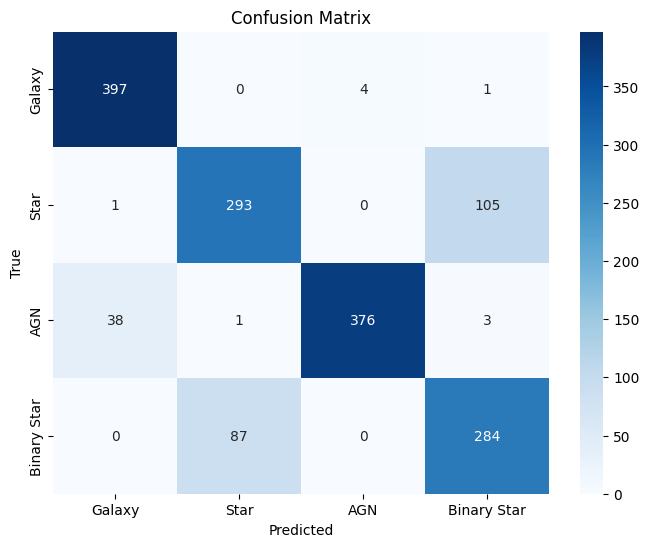

In [60]:
print_confusion_matrix(convnet_model, val_spectranan, val_labelsnan)